# Investment Risk Measurement

In [1]:
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Available data. The analyzed period is 20 years.

In [2]:
df = pd.read_csv('../data/BLK.csv')
df = df[::12]
df.reset_index(drop=True, inplace=True)

# Assessment of the real and normal distribution

In [3]:
df['yield'] = df['Close'].pct_change() * 100
df.loc[:, ['Open', 'Close', 'Date','yield']]

,Open,Close,Date,yield
0,14.000000,15.250000,1999-10-01,NaN
1,32.250000,42.625000,2000-10-01,179.508197
2,43.500000,43.250000,2001-10-01,1.466276
3,41.419998,35.720001,2002-10-01,-17.410402
4,49.000000,51.349998,2003-10-01,43.756989
5,73.489998,73.500000,2004-10-01,43.135351
6,88.870003,94.800003,2005-10-01,28.979596
7,149.000000,150.839996,2006-10-01,59.113915
8,174.050003,206.949997,2007-10-01,37.198358
9,191.000000,131.339996,2008-10-01,-36.535396


### Expected value

In [4]:
mu = df['yield'].mean()

### Dispersion and Standard Deviation

In [5]:
dispersion = df['yield'].var()
sigma = sqrt(dispersion)

### Skewness and Kurtosis

In [6]:
skew = df['yield'].skew()
kurtosis = df['yield'].kurt()

## Comparison of the real and normal distribution

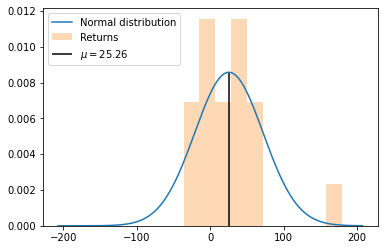

In [7]:
mn = mu - 5 * sigma 
xs = sorted(np.arange(mn, -mn, .05))
ys = [norm.pdf(x, mu, sigma) for x in xs]
h = sorted(np.asarray(df['yield'].dropna()))
plt.plot(xs, ys, label='Normal distribution')
plt.vlines(mu, 0, max(ys), label=f'$\mu = {mu:.2f}$')
plt.hist(h, density=True, histtype='stepfilled', alpha=0.3, label='Returns')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()
plt.show()

## Probability of profitability within the specified limits

In [8]:
def calc_returns(mu, sigma, i):
    dt = mu - sigma*(i+1)
    dt2 = mu + sigma*(i+1)
    if dt > -100:
        return (
            {'dt':dt}, 
            {'dt2': dt2}, 
            {'probability':norm.cdf(dt2, mu, sigma) - norm.cdf(dt, mu, sigma)}
        )
    else: 
        return (
            {'dt':-100}, 
            {'dt2':dt2}, 
            {'probability':norm.cdf(dt2, mu, sigma) - norm.cdf(dt, mu, sigma)}
        )

lst = [calc_returns(mu, sigma, i) for i in range(3)]

In [9]:
ll = [f'\nProbability={i[2]["probability"]:.2%} for values: {i[0]["dt"]:.2f} and {i[1]["dt2"]:.2f}' for i in lst]
print(
    f'\nmu={mu:.2f}', 
    f'\nsigma={sigma:.2f}', 
    f'\nskew={skew:.2f}', 
    f'\nkurtosis={kurtosis:.2f}'
)
print(*ll)
print(f'Bankrupt risk={norm.cdf(-100, mu, sigma):.9%}')


mu=25.26 
sigma=46.50 
skew=1.90 
kurtosis=5.70

Probability=68.27% for values: -21.24 and 71.76 
Probability=95.45% for values: -67.75 and 118.27 
Probability=99.73% for values: -100.00 and 164.77
Bankrupt risk=0.353467556%


## Change in annual profitability at various time intervals

In [10]:
def calc_period(year):
    if year == 1:
        return df['yield'].max(), df['yield'].mean(), df['yield'].min() 
    p_df = pd.DataFrame()
    length = len(df)
    n = 0
    for i in range(length):
        while i+year < length:
            start_price = df.loc[i,'Close']
            end_price = df.loc[i+year,'Close']
            p_df.loc[i+n,'Close'] = start_price
            p_df.loc[i+n+1,'Close'] = end_price
            # среднегодовая доходность
            p_df.loc[i+n+1,'yield'] = (pow((end_price/start_price), 1/(year+1)) - 1)*100 
            n += year
            break
    return  p_df['yield'].max(), p_df['yield'].mean(), p_df['yield'].min()
    

In [11]:
tbl_constr = {
    'Annual percentage yield': ['Max', 'Mean', 'Min'], 
    '1 year': calc_period(1),
    '3 years': calc_period(3),
    '5 years': calc_period(5),
    '7 years': calc_period(7),
    '10 years': calc_period(10)
}
tbl_df = pd.DataFrame(data=tbl_constr)
tbl_df

,Annual percentage yield,1 year,3 years,5 years,7 years,10 years
0,Max,179.508197,30.916390,34.016723,33.169826,27.274836
1,Mean,25.260889,12.335148,13.985869,14.490996,13.474177
2,Min,-36.535396,-4.659741,-1.441818,5.852900,7.127755


## Diagram of annual profitability at various time intervals

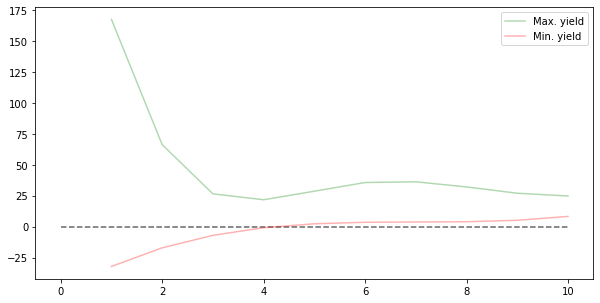

In [12]:
xs = sorted(np.arange(1, 11, 1))
ys_max = [calc_period(x)[0] for x in xs]
ys_min = [calc_period(x)[2] for x in xs]

from scipy.interpolate import splrep, splev

bspl_max = splrep(xs, ys_max, s=1000)
bspl_y_max = splev(xs, bspl_max)

bspl_min = splrep(xs, ys_min, s=1000)
bspl_y_min = splev(xs, bspl_min)

plt.plot(xs, bspl_y_max, label='Max. yield', alpha=0.3, color='green')
plt.plot(xs, bspl_y_min, label='Min. yield', alpha=0.3, color='red')
plt.hlines(0, 0, 10, label=f'', alpha=0.6, linestyle='--')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()
plt.show()